In [230]:
# Libraries and data setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from matplotlib.colors import LinearSegmentedColormap

colors = {
    'precision': '#59A14F',
    'recall':    '#F28E2B',
    'f1_score':  '#4682B4',
    'parameter_efficiency':  '#4682B4',
    'time_efficiency':  '#4682B4',
    'efficiency_log':  '#4682B4',
    'avg_processing_time':  '#4682B4'
}

df_manual = pd.read_parquet(
    '../data/manual_predictions.parquet',
    columns=['id','rating']
    ).rename(
        columns={'rating':'rating_manual'}
    )
df_llm = pd.read_parquet(
    '../data/llm_predictions.parquet',
    columns=['id','model','rating','processing_time']
    ).rename(
        columns={'rating':'rating_llm'}
    )
df_comments = pd.read_parquet(
    '../data/comments_sample.parquet',
    columns=['id','rating','comment_length_group','language']
    ).rename(
        columns={'rating':'rating_real'}
    )

print(f"Comments manually predicted: {len(df_manual)}")
print(f"LLM predictions: {len(df_llm)}")
print(f"LLM models: {set(df_llm['model'])}")
print('\n')

df = (
    df_manual
    .merge(df_llm, on='id', how='left')
    .merge(df_comments, on='id', how='inner')
    )

for type in ['manual','llm']:
    df[f'is_inconsistent_{type}'] = (
        (df[f'rating_{type}'] - df['rating_real']).abs() > 1
        ).astype(int)


df_pt = df[df['language']=='pt']
df_en = df[df['language']=='en']

df.info()

Comments manually predicted: 1029
LLM predictions: 28675
LLM models: {'stablelm2:1.6b', 'yi:6b', 'qwen3:4b', 'gemma3:1b', 'mistral-openorca:7b', 'deepseek-r1:1.5b', 'gemma:2b', 'llama3.2:3b', 'gemma3:4b', 'gemma3:12b', 'llama2:7b', 'llama3.1:8b', 'qwen2.5:3b', 'orca-mini:7b', 'phi3:3.8b', 'qwen2.5:0.5b', 'yi:9b', 'stablelm2:12b', 'olmo2:7b', 'orca-mini:3b', 'qwen3:1.7b', 'qwen3:0.6b', 'mistral-nemo:12b', 'qwen3:8b', 'gemma:7b', 'orca2:7b', 'deepseek-r1:8b', 'llama2:13b', 'qwen2.5:1.5b'}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28675 entries, 0 to 28674
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      28675 non-null  object 
 1   rating_manual           28675 non-null  int64  
 2   model                   28675 non-null  object 
 3   rating_llm              28674 non-null  float64
 4   processing_time         28675 non-null  float64
 5   rating_real          

In [231]:
def gen_model_metrics_df(df):
    y_true = df['is_inconsistent_manual']
    y_pred = df['is_inconsistent_llm']

    df = df.dropna(subset=['model'])

    metrics = []
    for model, group in df.groupby('model'):
        y_true = group['is_inconsistent_manual']
        y_pred = group['is_inconsistent_llm']

        metrics.append({
            'model': model,
            'accuracy':  accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall':    recall_score(y_true, y_pred, zero_division=0),
            'f1_score':  f1_score(y_true, y_pred, zero_division=0)
        })

    model_metrics_df = pd.DataFrame(metrics).sort_values('f1_score', ascending=False)

    model_metrics_df['parameters'] = (
        model_metrics_df['model']
        .str.extract(r':([\d\.]+)b')[0]
        .astype(float)
    )

    mean_times = (
        df
        .groupby('model')['processing_time']
        .mean()
        .reset_index(name='avg_processing_time')
        .round(2)
    )

    model_metrics_df = model_metrics_df.merge(mean_times,on='model',how='left')
    return model_metrics_df

model_metrics_df = gen_model_metrics_df(df)
model_metrics_pt_df = gen_model_metrics_df(df_pt)
model_metrics_en_df = gen_model_metrics_df(df_en)

display(model_metrics_df.head())


,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,stablelm2:12b,0.873,0.649485,0.681081,0.664908,12.0,7.83
1,llama2:7b,0.825,0.517606,0.794595,0.626866,7.0,5.21
2,orca-mini:7b,0.841,0.565000,0.610811,0.587013,7.0,4.97
3,orca2:7b,0.862,0.664336,0.513514,0.579268,7.0,4.92
4,qwen3:4b,0.829,0.531818,0.632432,0.577778,4.0,2.43


In [232]:
# Model groups
def gen_model_groups(df):
    small_3 = df.nsmallest(3, 'parameters')['model'].tolist()
    small_5 = df.nsmallest(5, 'parameters')['model'].tolist()
    big_3   = df.nlargest(3,  'parameters')['model'].tolist()
    big_5   = df.nlargest(5,  'parameters')['model'].tolist()

    fast_3 = df.nsmallest(3, 'avg_processing_time')['model'].tolist()
    fast_5 = df.nsmallest(5, 'avg_processing_time')['model'].tolist()
    slow_3 = df.nlargest(3,  'avg_processing_time')['model'].tolist()
    slow_5 = df.nlargest(5,  'avg_processing_time')['model'].tolist()

    groups = {
        'small-3': small_3,
        'small-5': small_5,
        'big-3':   big_3,
        'big-5':   big_5,
        'fast-3':  fast_3,
        'fast-5':  fast_5,
        'slow-3':  slow_3,
        'slow-5':  slow_5
    }
    return groups

groups = gen_model_groups(model_metrics_df)
groups_pt = gen_model_groups(model_metrics_pt_df)
groups_en = gen_model_groups(model_metrics_en_df)

for label, models in groups.items():
    print(f"{label:7}: {models}")

small-3: ['qwen2.5:0.5b', 'qwen3:0.6b', 'gemma3:1b']
small-5: ['qwen2.5:0.5b', 'qwen3:0.6b', 'gemma3:1b', 'deepseek-r1:1.5b', 'qwen2.5:1.5b']
big-3  : ['llama2:13b', 'stablelm2:12b', 'mistral-nemo:12b']
big-5  : ['llama2:13b', 'stablelm2:12b', 'mistral-nemo:12b', 'gemma3:12b', 'yi:9b']
fast-3 : ['qwen2.5:0.5b', 'qwen3:0.6b', 'qwen2.5:1.5b']
fast-5 : ['qwen2.5:0.5b', 'qwen3:0.6b', 'qwen2.5:1.5b', 'gemma3:1b', 'deepseek-r1:1.5b']
slow-3 : ['llama2:13b', 'stablelm2:12b', 'yi:9b']
slow-5 : ['llama2:13b', 'stablelm2:12b', 'yi:9b', 'mistral-nemo:12b', 'gemma3:12b']


In [233]:
def gen_group_metrics_df(df, groups):
    param_df = pd.DataFrame({
            'model': [m for modelos in groups.values() for m in modelos],
            'parameters': [float(m.split(':')[1].replace('b',''))
                        for modelos in groups.values() for m in modelos]
        })

    time_df = (
        df
        .groupby('model')['processing_time']
        .mean()
        .reset_index(name='avg_processing_time')
        .round(2)
    )

    group_models = pd.DataFrame([
        {'group': f'group:{g}', 'model': m}
        for g, modelos in groups.items()
        for m in modelos
    ])

    group_stats = (
        group_models
        .merge(param_df, on='model')
        .merge(time_df, on='model')
        .groupby('group')
        .agg(parameters=('parameters','sum'),
            avg_processing_time=('avg_processing_time','sum'))
        .reset_index()
    )

    metrics = []
    manual = df[['id','is_inconsistent_manual']].drop_duplicates('id').set_index('id')

    for group_name, modelos in groups.items():
        sub = df[df['model'].isin(modelos)].drop_duplicates(['id','model'])
        wide = (
            sub
            .pivot(index='id', columns='model', values='is_inconsistent_llm')
            .fillna(0).astype(int)
        )
        threshold = len(modelos) / 2
        y_pred = (wide.sum(axis=1) > threshold).astype(int)
        y_true = manual.loc[y_pred.index, 'is_inconsistent_manual']
        metrics.append({
            'group':     f'group:{group_name}',
            'accuracy':  accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall':    recall_score(y_true, y_pred, zero_division=0),
            'f1_score':  f1_score(y_true, y_pred, zero_division=0)
        })

    group_metrics_df = (
        pd.DataFrame(metrics)
        .sort_values('f1_score', ascending=False)
        .merge(group_stats, on='group', how='left')
        .rename(columns={'group':'model'})
        .reset_index(drop=True)
    )
    return group_metrics_df

group_metrics_df = gen_group_metrics_df(df, groups)
group_metrics_pt_df = gen_group_metrics_df(df_pt, groups_pt)
group_metrics_en_df = gen_group_metrics_df(df_en, groups_en)

display(group_metrics_df.head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time
0,group:big-3,0.868,0.682759,0.535135,0.600000,136.0,88.28
1,group:big-5,0.859,0.648649,0.518919,0.576577,187.0,121.50
2,group:slow-5,0.859,0.648649,0.518919,0.576577,187.0,121.50
3,group:slow-3,0.856,0.639456,0.508108,0.566265,127.0,89.54
4,group:fast-5,0.748,0.391586,0.654054,0.489879,14.9,10.20


In [234]:
def gen_metrics_df(model_metrics_df, group_metrics_df):
    metrics_df = pd.concat([model_metrics_df, group_metrics_df])
    metrics_df['parameter_efficiency'] = metrics_df['f1_score'] / metrics_df['parameters']
    metrics_df['time_efficiency'] = metrics_df['f1_score'] / metrics_df['avg_processing_time']

    metrics_df['time_log'] = np.log1p(metrics_df['avg_processing_time'])
    metrics_df['efficiency_log'] = metrics_df['f1_score'] / metrics_df['time_log']
    return metrics_df

metrics_df = gen_metrics_df(model_metrics_df, group_metrics_df)
metrics_pt_df = gen_metrics_df(model_metrics_pt_df, group_metrics_pt_df)
metrics_en_df = gen_metrics_df(model_metrics_en_df, group_metrics_en_df)

metrics_df = metrics_df.merge(metrics_pt_df, on='model', how='left', suffixes=["", "_pt"])
metrics_df = metrics_df.merge(metrics_en_df, on='model', how='left', suffixes=["", "_en"])

display(metrics_df.sort_values(by='f1_score', ascending=False).head())

,model,accuracy,precision,recall,f1_score,parameters,avg_processing_time,parameter_efficiency,time_efficiency,time_log,...,accuracy_en,precision_en,recall_en,f1_score_en,parameters_en,avg_processing_time_en,parameter_efficiency_en,time_efficiency_en,time_log_en,efficiency_log_en
0,stablelm2:12b,0.873,0.649485,0.681081,0.664908,12.0,7.83,0.055409,0.084918,2.178155,...,0.884,0.752688,0.666667,0.707071,12.0,6.88,0.058923,0.102772,2.064328,0.342519
1,llama2:7b,0.825,0.517606,0.794595,0.626866,7.0,5.21,0.089552,0.120320,1.826161,...,0.836,0.583942,0.761905,0.661157,7.0,4.51,0.094451,0.146598,1.706565,0.387420
29,group:big-3,0.868,0.682759,0.535135,0.600000,136.0,88.28,0.004412,0.006797,4.491777,...,0.860,0.716049,0.552381,0.623656,148.0,85.20,0.004214,0.007320,4.456670,0.139938
2,orca-mini:7b,0.841,0.565000,0.610811,0.587013,7.0,4.97,0.083859,0.118111,1.786747,...,0.840,0.619048,0.619048,0.619048,7.0,4.25,0.088435,0.145658,1.658228,0.373319
3,orca2:7b,0.862,0.664336,0.513514,0.579268,7.0,4.92,0.082753,0.117737,1.778336,...,0.852,0.724638,0.476190,0.574713,7.0,4.25,0.082102,0.135227,1.658228,0.346582


In [235]:
def gen_hbar_graph(metrics_df, metric, metric_name):
    metrics_df = metrics_df.sort_values(metric, ascending=True)
    models = metrics_df['model'].tolist()
    y = np.arange(len(models))
    bar_height = 0.6

    fig, ax = plt.subplots()

    bars_f1 = ax.barh(
        y,
        metrics_df[metric],
        color=colors[metric],
        edgecolor='black',
        height=bar_height,
        label=metric_name
    )

    for bar, model in zip(bars_f1, models):
        if model.lower().startswith("group"):
            bar.set_hatch("///")

    ax.bar_label(bars_f1, fmt='%.3f', padding=3, fontsize=6)

    ax.set_yticks(y)
    ax.set_yticklabels(models, fontsize=7)
    ax.set_title(f'Desempenho do Modelo/Grupo: {metric_name}', fontsize=10, pad=12)
    ax.set_xlabel(metric_name, fontsize=8)
    ax.set_ylabel('Modelo / Groupo', fontsize=8)
    ax.legend(fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.savefig(f'../images/hbar_{metric}.png')

def gen_hbar_lang_graph(metrics_df, metric, metric_name):
    """
    Gera um gráfico com dois horizontais side-by-side: 
    um para dados em português (_pt) e outro para inglês (_en).

    Parâmetros:
    - metrics_df: DataFrame com colunas 'model', metric_pt, metric_en
    - metric: string, base do nome da coluna (ex: 'f1_score')
    - metric_name: string, nome legível da métrica (ex: 'F1-score')
    """
    langs = ['pt', 'en']
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6), dpi=120, sharex=True)

    for ax, lang in zip(axes, langs):
        col = f"{metric}_{lang}"
        df_lang = metrics_df.dropna(subset=[col]).sort_values(col, ascending=False)
        models = df_lang['model'].tolist()
        y = np.arange(len(models))
        bar_height = 0.6

        bars = ax.barh(
            y,
            df_lang[col],
            color=colors[metric],
            edgecolor='black',
            height=bar_height,
            label=f"{metric_name} ({lang})"
        )

        # aplicar hatch apenas em modelos que começam com "group"
        for bar, model in zip(bars, models):
            if model.lower().startswith("group"):
                bar.set_hatch("///")

        ax.bar_label(bars, fmt='%.3f', padding=3, fontsize=6)
        ax.set_yticks(y)
        ax.set_yticklabels(models, fontsize=7)
        ax.invert_yaxis()
        ax.set_title(f"{metric_name} — {lang.upper()}", fontsize=10, pad=8)
        ax.set_xlabel(metric_name, fontsize=8)
        ax.set_ylabel('Model / Group', fontsize=8)

    # Ajustes finais
    plt.suptitle(f'Comparação de {metric_name} por Linguagem', fontsize=12, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.savefig(f'../images/hbar_{metric}_lang.png', dpi=120)
    plt.show()

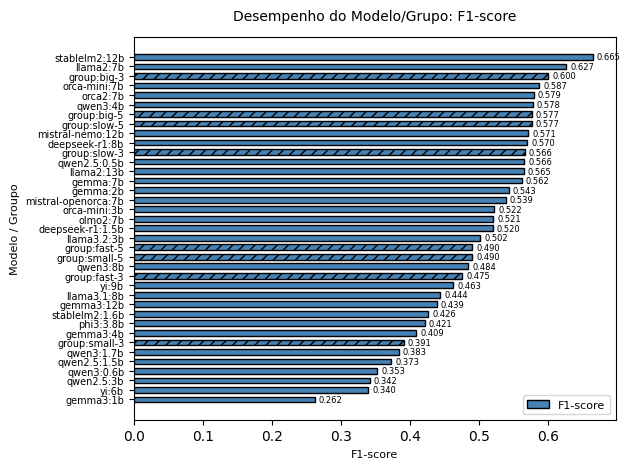

<Figure size 640x480 with 0 Axes>

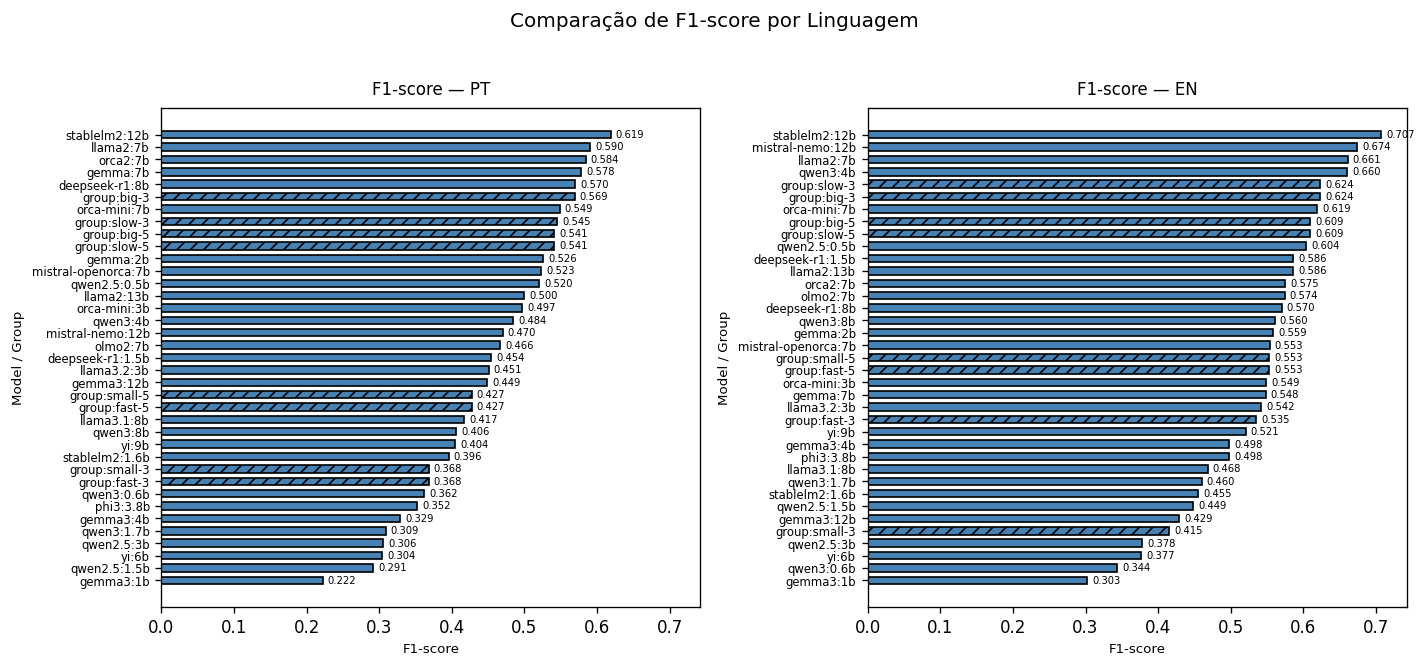

In [236]:
gen_hbar_graph(metrics_df, 'f1_score', 'F1-score')
gen_hbar_lang_graph(metrics_df, 'f1_score', 'F1-score')


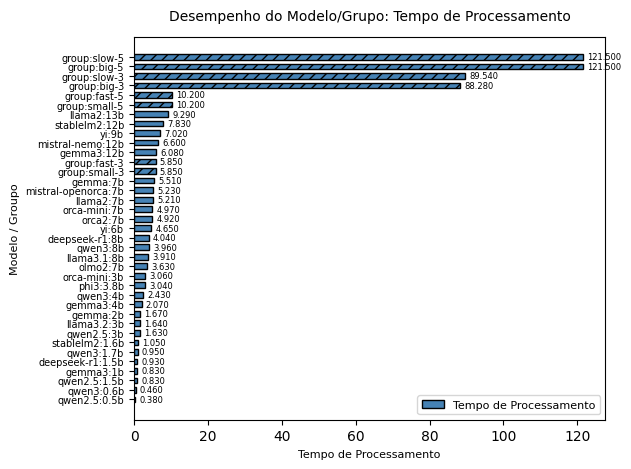

<Figure size 640x480 with 0 Axes>

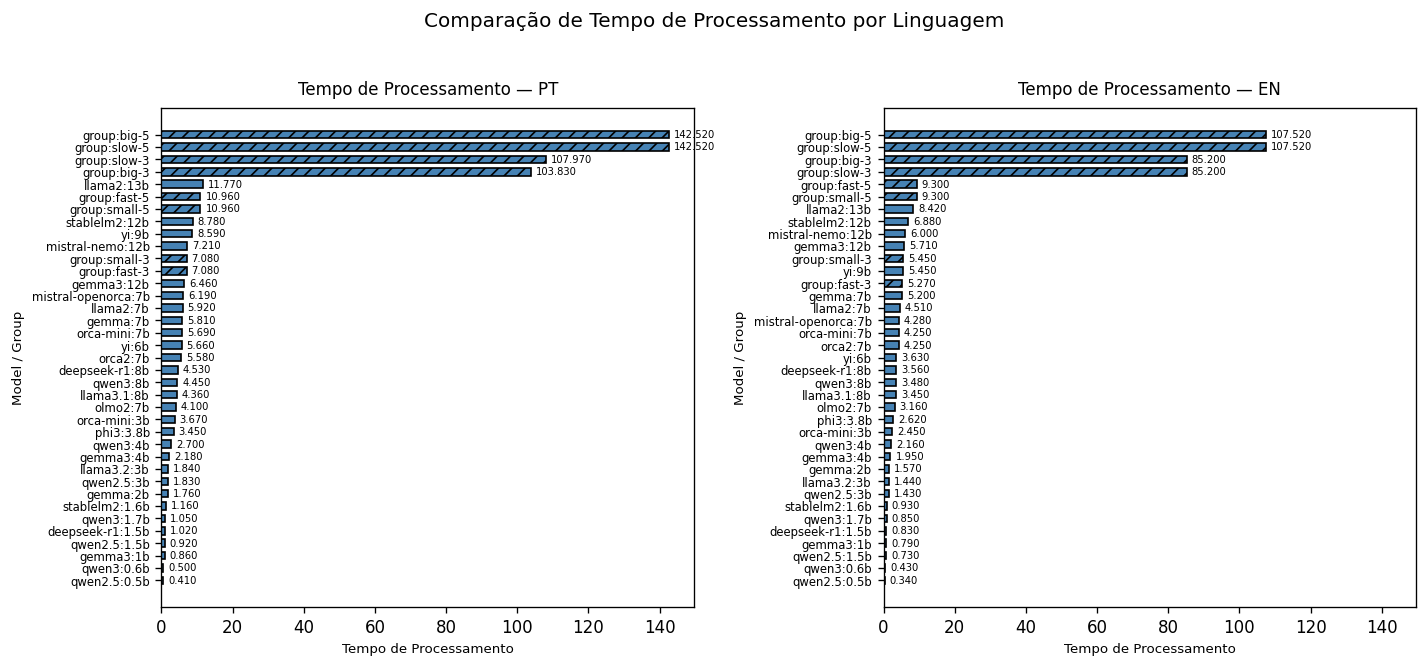

In [237]:
gen_hbar_graph(metrics_df, 'avg_processing_time', 'Tempo de Processamento')
gen_hbar_lang_graph(metrics_df, 'avg_processing_time', 'Tempo de Processamento')

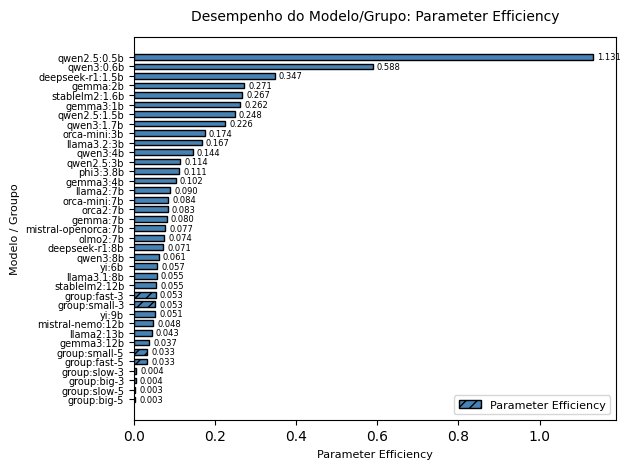

<Figure size 640x480 with 0 Axes>

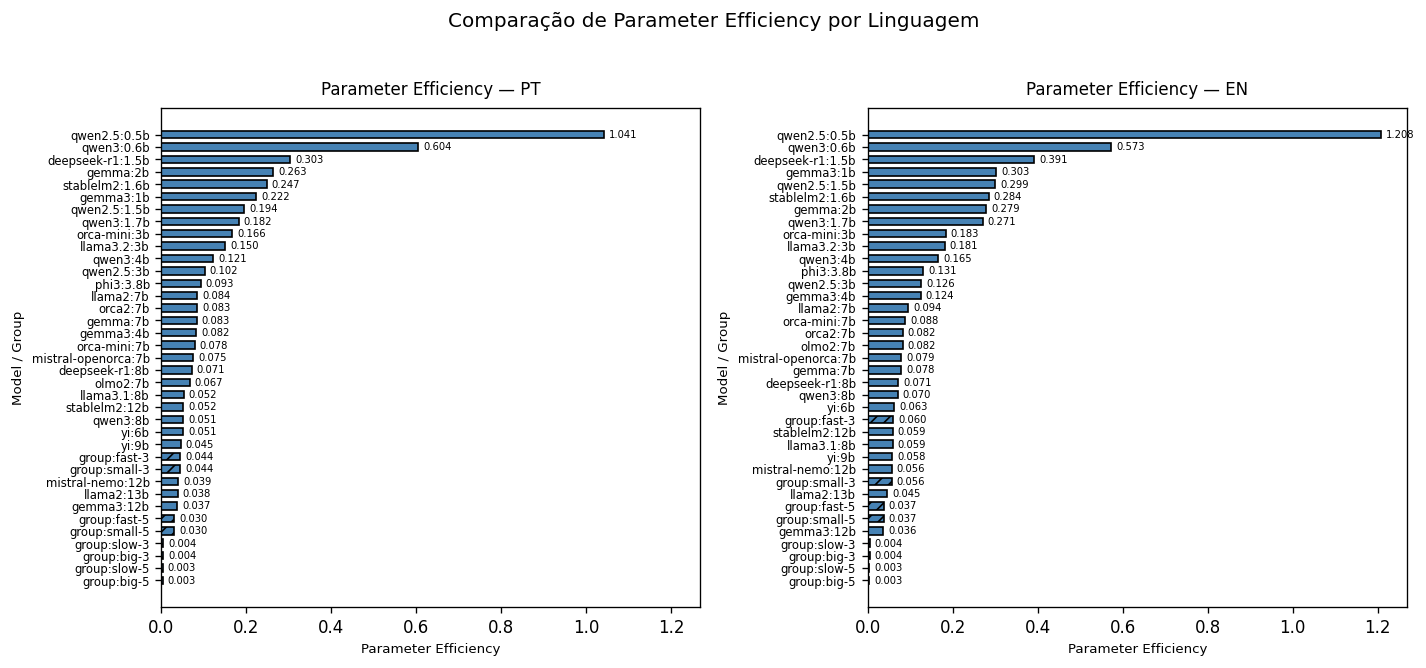

In [238]:
gen_hbar_graph(metrics_df, 'parameter_efficiency', 'Parameter Efficiency')
gen_hbar_lang_graph(metrics_df, 'parameter_efficiency', 'Parameter Efficiency')

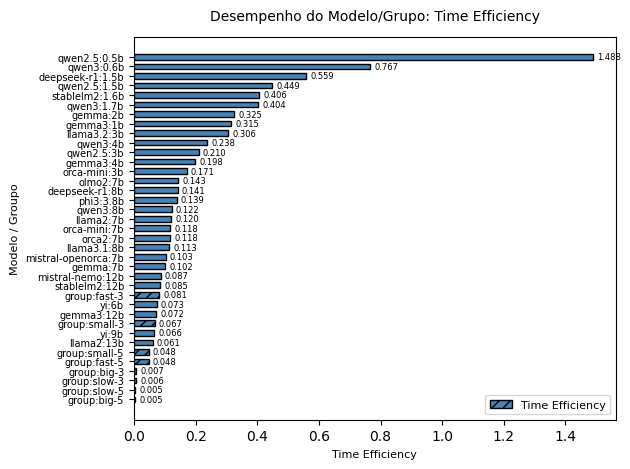

<Figure size 640x480 with 0 Axes>

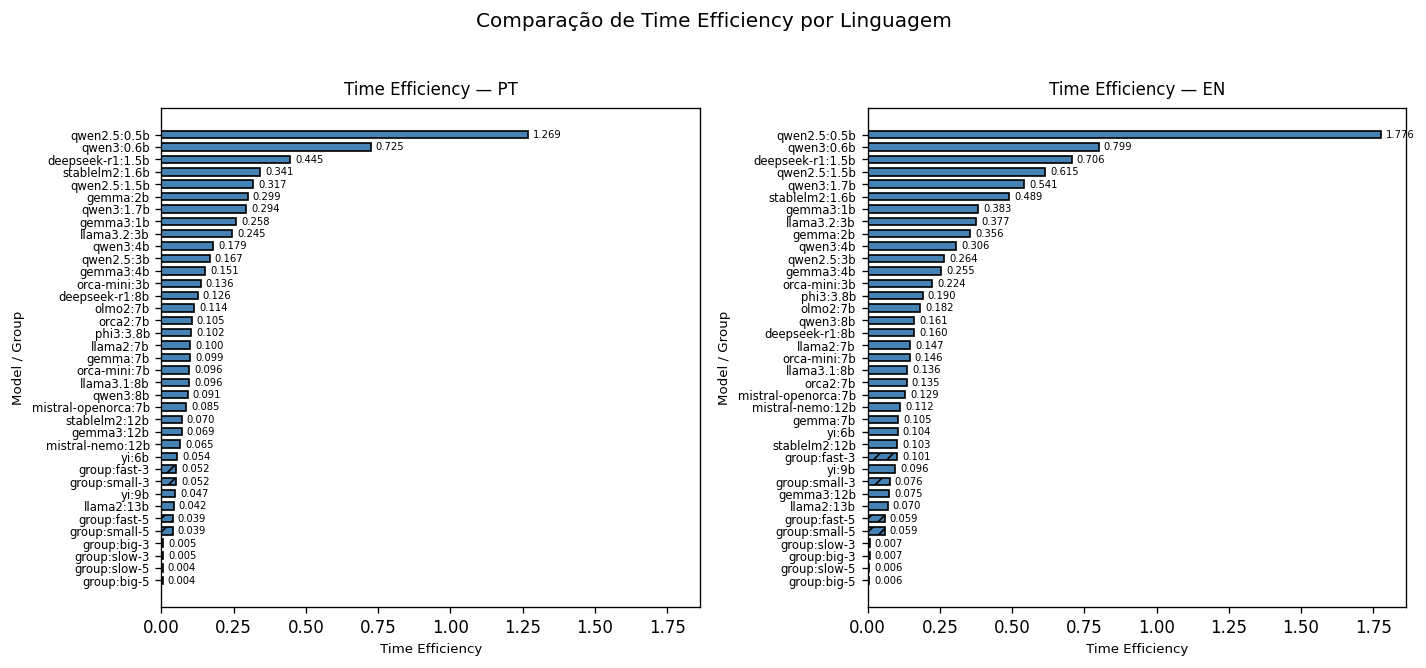

In [239]:
gen_hbar_graph(metrics_df, 'time_efficiency', 'Time Efficiency')
gen_hbar_lang_graph(metrics_df, 'time_efficiency', 'Time Efficiency')

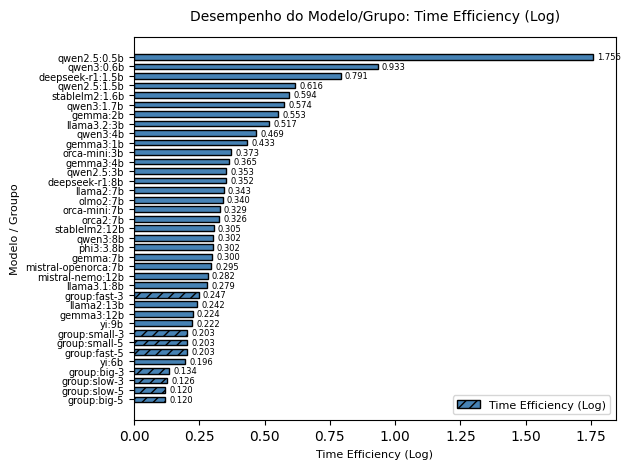

<Figure size 640x480 with 0 Axes>

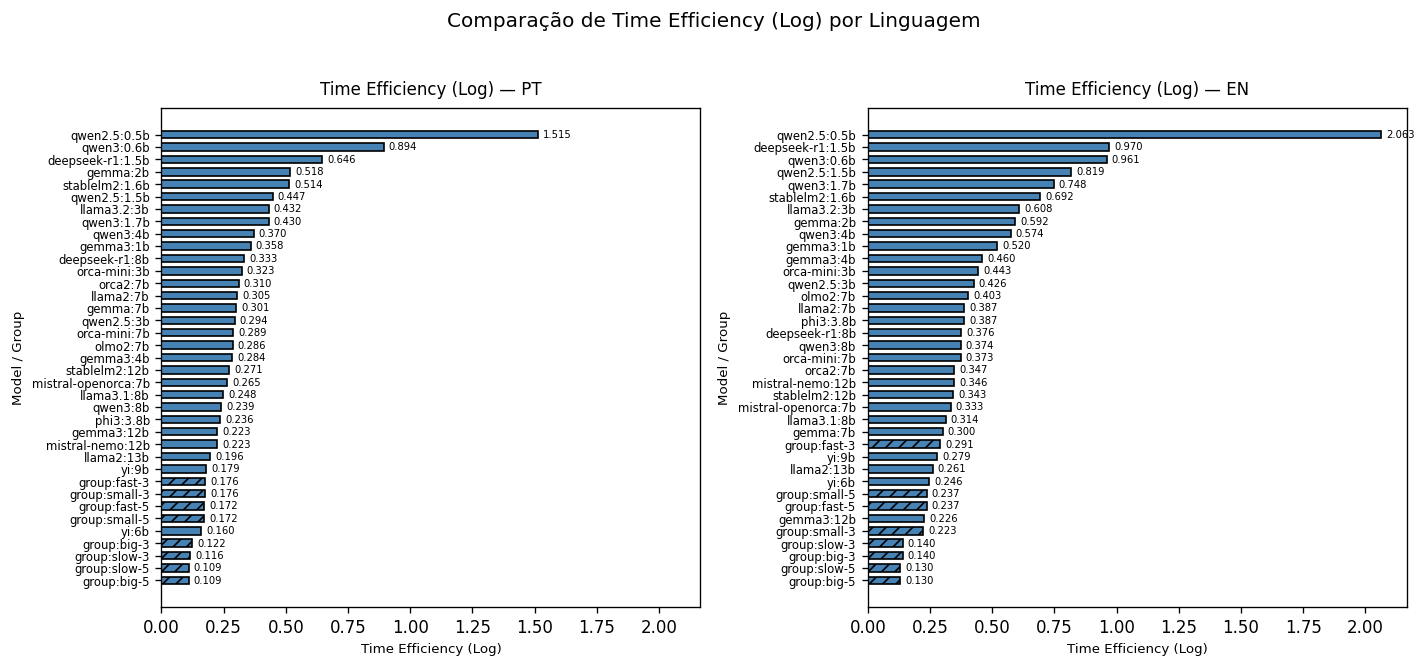

In [240]:
gen_hbar_graph(metrics_df, 'efficiency_log', 'Time Efficiency (Log)')
gen_hbar_lang_graph(metrics_df, 'efficiency_log', 'Time Efficiency (Log)')

In [241]:
# f1_by_rating
ratings = sorted(df['rating_real'].unique())

records = []
for model, grp in df.dropna(subset=['model']).groupby('model'):
    for r in ratings:
        y_true = (grp['rating_real'] == r).astype(int)
        y_pred = (grp['rating_llm'] == r).astype(int)
        records.append({
            'model':       model,
            'real_rating': r,
            'f1_score':    f1_score(y_true, y_pred, zero_division=0)
        })

wide_ratings = df.pivot(index='id', columns='model', values='rating_llm')
manual = df[['id','rating_real']].drop_duplicates('id').set_index('id')

for group_name, modelos in groups.items():
    grp_wide = wide_ratings[modelos]
    group_pred = grp_wide.mode(axis=1)[0].fillna(0).astype(int)
    y_true_full = manual['rating_real']
    for r in ratings:
        y_true = (y_true_full == r).astype(int).loc[group_pred.index]
        y_pred = (group_pred == r).astype(int)
        records.append({
            'model':       f'{group_name}_majority',
            'real_rating': r,
            'f1_score':    f1_score(y_true, y_pred, zero_division=0)
        })

f1_by_rating = (
    pd.DataFrame(records)
      .pivot(index='model', columns='real_rating', values='f1_score')
      .fillna(0)
)

display(f1_by_rating.head())


real_rating,1,2,3,4,5
model,,,,,
big-3_majority,0.169811,0.458554,0.327327,0.101695,0.238462
big-5_majority,0.253275,0.465517,0.316476,0.132450,0.318841
deepseek-r1:1.5b,0.280992,0.048544,0.344526,0.359926,0.329268
deepseek-r1:8b,0.413115,0.346154,0.352436,0.128114,0.437500
fast-3_majority,0.392157,0.308668,0.280236,0.070485,0.386076


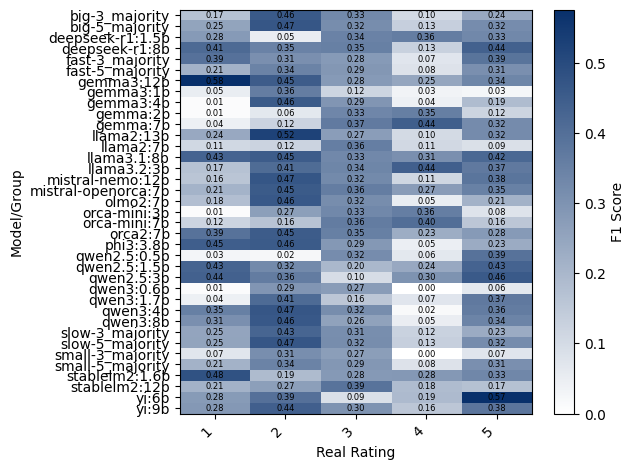

<Figure size 640x480 with 0 Axes>

In [242]:
# f1 by rating heatmap (all)

heatmap_data = f1_by_rating.values
models = f1_by_rating.index.tolist()
ratings = f1_by_rating.columns.tolist()

cmap = LinearSegmentedColormap.from_list(
    'white_to_dark_blue',
    ['#ffffff', '#08306b']
)

vmax = np.nanmax(heatmap_data)

fig, ax = plt.subplots()
im = ax.imshow(
    heatmap_data,
    aspect='auto',
    cmap=cmap,
    vmin=0,
    vmax=vmax
)

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(models)):
    for j in range(len(ratings)):
        ax.text(
            j, i,
            f"{heatmap_data[i, j]:.2f}",
            ha='center', va='center',
            fontsize=6,
            color='black'
        )

ax.set_xlabel('Real Rating')
ax.set_ylabel('Model/Group')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('F1 Score')

plt.tight_layout()
plt.show()
plt.savefig('../images/f1-score-heatmap')


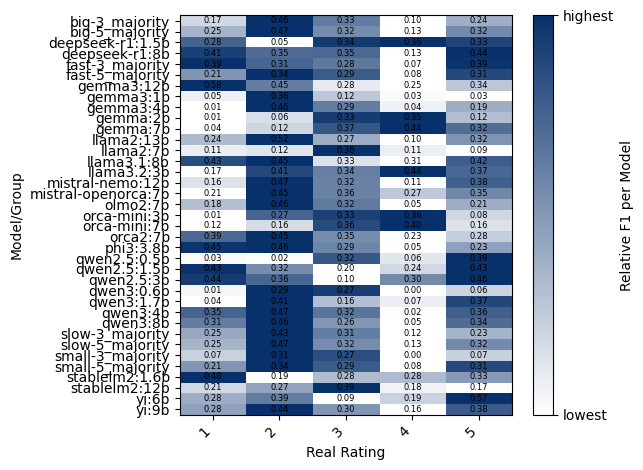

<Figure size 640x480 with 0 Axes>

In [243]:
# f1 by rating heatmap (by model)

data = f1_by_rating.values
models = f1_by_rating.index.tolist()
ratings = f1_by_rating.columns.tolist()

row_min = data.min(axis=1, keepdims=True)
row_max = data.max(axis=1, keepdims=True)
norm_data = (data - row_min) / (row_max - row_min + 1e-9)

cmap = LinearSegmentedColormap.from_list(
    'white_to_dark_blue',
    ['#ffffff', '#08306b']
)

fig, ax = plt.subplots()
im = ax.imshow(norm_data, aspect='auto', cmap=cmap, vmin=0, vmax=1)

ax.set_xticks(np.arange(len(ratings)))
ax.set_xticklabels(ratings)
ax.set_yticks(np.arange(len(models)))
ax.set_yticklabels(models)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

for i in range(len(models)):
    for j in range(len(ratings)):
        ax.text(
            j, i,
            f"{data[i, j]:.2f}",
            ha='center', va='center',
            fontsize=6,
            color='black'
        )

ax.set_xlabel('Real Rating')
ax.set_ylabel('Model/Group')

cbar = fig.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_ticklabels(['lowest', 'highest'])
cbar.set_label('Relative F1 per Model')

plt.tight_layout()
plt.show()
plt.savefig('../images/f1-score-heatmap-by-model')